In [35]:
from tensorflow.keras.utils import plot_model
import tensorflow.keras as keras 


### ANN model for sine fitting

In [36]:
class SineModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1) 
    
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x) 
        return x 

### Sinusoid Generator

In [50]:
import numpy as np 
import matplotlib.pyplot as plt 

class SinusoidGenerator():
    ''' 
    Sinusoid Generator.

    p(T) is continuous, where the amplitude varies within [0.1, 5.0]
    and the phase varies within [0, pi]
    '''

    def __init__(self, K=10, amplitude=None, phase=None):
        ''' 
        Args:
        K: batch size. Number of values sampled at every batch
        amplitude: Sine wave Amplitude. If None, uniformly sampled from [0.1, 5.0]
        phase: Sine wave phase. If None, uniformly sample from [0, pi] interval
        '''
        self.K = K 
        self.amplitude = amplitude if amplitude else np.random.uniform(0.1, 5.0)
        self.phase = phase if amplitude else np.random.uniform(0, np.pi)
        self.sampled_points = None 
        self.x = self._sample_x() 
    
    def _sample_x(self):
        return np.random.uniform(-5, 5, self.K) 

    def f(self, x):
        '''Sine wave function'''
        return self.amplitude * np.sin(x - self.phase) 

    def batch(self, x = None, force_new=False):
        print(x)
        if x is None:
            if force_new:
                x = self._sample_x() 
            else: 
                x = self.x 
        y = self.f(x) 
        return x[:, None], y[:, None] 

    def equally_spaced_samples(self, K=None):
        """Returns `K` equally spaced samples"""
        if K is None:
            K = self.K 
        return self.batch(x=np.linspace(-5, 5, K))

### Util Functions

In [4]:
def plot(data, *args, **kwargs):
    x, y = data 
    return plt.plot(x, y, *args, **kwargs) 

def generate_dataset(K, train_size=20000, test_size=10):
    def _generate_dataset(size):
        return [SinusoidGenerator(K=K) for _ in range(size)]
    return _generate_dataset(train_size), _generate_dataset(test_size)

### Train Sine Model 

In [37]:
import os 
import sys 
import random 
import numpy as np 
import tensorflow as tf 
import time 
import matplotlib.pyplot as plt 

# tf.keras.backend.set_floatx('float64')

def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)

def copy_model(mode, x):
    copied_model = SineModel() 
    copied_model.forward(x) 
    copied_model.set_weights(mode.get_weights())
    return copied_model 

def loss_fn(y, pred_y):
    return tf.reduce_mean(tf.keras.metrics.mean_squared_error(y, pred_y))

def compute_loss(model, x, y, loss_fn=loss_fn):
    logits = model.forward(x) 
    mse = loss_fn(logits, y) 
    return mse, logits 

def compute_gradients(model, x, y, loss_fn=loss_fn):
    with tf.GradientTape() as tape:
        loss, logits = compute_loss(model, x, y, loss_fn) 
    return tape.gradient(loss, model.trainable_variables), loss 

def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

def train_step(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss = compute_gradients(model, tensor_x, tensor_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return loss 

def regular_train(model, train_ds, epochs=1, lr=0.001, log_steps=1000):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        losses = []
        total_loss = 0 
        start = time.time() 
        for i, sinusoid_generator in enumerate(train_ds):
            x, y = sinusoid_generator.batch()
            loss = train_step(x, y, model, optimizer)
            total_loss += loss 
            curr_loss = total_loss / (i + 1.0) 
            losses.append(curr_loss)

            if i % log_steps == 0 and i > 0 : 
                print(f"step{i}: loss={curr_loss}, Time to run {log_steps} steps = {time.time()-start:.2f} seconds")
                start = time.time() 
        plt.plot(losses)
        plt.title("Loss")
        plt.show() 
    return model 

def maml_train(model, train_ds, epochs=1, lr_inner=0.01, batch_size=1, log_steps=1000):
    optimizer = tf.keras.optimizers.Adam() 
    for epoch in range(epochs):
        losses = []
        total_loss = 0 
        start = time.time() 

        for i, ds in enumerate(random.sample(train_ds, len(train_ds))):
            x, y = np_to_tensor(ds.batch())
            model.forward(x)
            with tf.GradientTape() as test_tape:
                with tf.GradientTape() as train_tape:
                    train_loss, _ = compute_loss(model, x, y) 
                gradients = train_tape.gradient(train_loss, model.trainable_variables)
                k=0
                model_copy = copy_model(model, x) 

                for j in range(len(model_copy.layers)):
                    model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel, tf.multiply(lr_inner, gradients[k]))
                    model_copy.layers[j].bias = tf.subtract(model.layers[j].bias, tf.multiply(lr_inner, gradients[k+1]))
                    k += 2 
                test_loss, logits = compute_loss(model_copy, x, y)
            gradients = test_tape.gradient(test_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # logs 
            total_loss += test_loss
            loss = total_loss / (i+1.0) 
            losses.append(loss)

            if i % log_steps == 0 and i > 0 :
                print(f"step{i}: loss={loss}, Time to run {log_steps} steps = {time.time()-start:.2f} seconds")
                start = time.time() 
        plt.plot(losses)
        plt.title("Loss-MAML")
        plt.show()
        return model 

def plot_model_comparison_to_average(model, ds, model_name='lll', K=5):
    '''Compare model to average
    
    Computes mean of training sine waves actual `y` and compare to 
    the model's prediction to a new sinewave, the intuition is that 
    these two plots should be similar '''
    sinu_generator = SinusoidGenerator(K=K)

    # calculate average prediction 
    avg_pred = [] 
    for i, sinusoid_generator in enumerate(ds):
        x, y = sinusoid_generator.equally_spaced_samples() 
        avg_pred.append(y) 
    
    x, _ = sinu_generator.equally_spaced_samples()
    avg_plot, = plt.plot(x, np.mean(avg_pred, axis=0), '--')

    # calculate model prediction
    model_pred = model.forward(tf.convert_to_tensor(x))
    model_plot, = plt.plot(x, model_pred.numpy())

    # plot 
    plt.legend([avg_plot, model_plot], ["average plot", model_name]) 
    plt.title(model_name)
    plt.show() 

def eval_sine_test(model, optimizer, x, y, x_test, y_test, num_steps=(0, 1, 10)):
    """Evaluate how the model fits to the curve training for `fits` steps.
    
    Args: 
        model: Model evaluated.
        optimizer: Optimizer to be for training
        x : Data used for training 
        y : Targets used for training 
        x_test : Data used for evaluation 
        y_test : Targets used for evaluation 
        num_steps : Number of steps to log 
    """
    fit_res = [] 

    tensor_x_test, tensor_y_test = np_to_tensor((x_test, y_test)) 

    if 0 in num_steps: 
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        fit_res.append((0, logits, loss)) 
    
    for step in range(1, np.max(num_steps) + 1 ):
        train_step(x, y, model, optimizer)
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        if step in num_steps:
            fit_res.append(
                (
                    step,
                    logits,
                    loss
                )
            )
    return fit_res 

def eval_sinewave_for_test(model, sinusoid_generator=None, num_steps=(0, 1, 10), lr=0.01, plot=True, name=None):
    """Evaluates how the sinewave adapts at dataset.
    
    The idea is to use the pretrained model as a weight initializer and try to fit the model
    on this new dataset. 
    
    Args:
        model : Already trained model
        sinusoid_generator : A sinusoid Generator instance 
        num_steps : Number of training steps to be logged.
        lr : learning rate used for training on the test data 
        plot : If plot is True, plots how the curves are fitted along `num_steps`
    """

    if sinusoid_generator is None:
        sinusoid_generator = SinusoidGenerator(K=5)
    
    # Generate equally spaced samples for plotting 
    x_test, y_test = sinusoid_generator.equally_spaced_samples(100)

    # batch used for training 
    x, y = sinusoid_generator.batch() 

    # copy model so we can use the same model multiple times 
    copied_model = copy_model(model, x) 

    # use SGD for this part of training as described in the paper 
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr) 

    # run training and log fit results
    fit_res = eval_sine_test(copied_model, optimizer, x, y, x_test, y_test, num_steps)

    # plot 
    train, = plt.plot(x, y, '^')
    ground_truth, = plt.plot(x_test, y_test)
    plots = [train, ground_truth]
    legend = ["trained", "True value"]

    for n, res, loss in fit_res:
        cur, = plt.plot(x_test, res[:, 0], '--')
        plots.append(cur)
        legend.append(f"{n}-th steps")
    plt.legend(plots, legend)
    plt.ylim(-5, 5)
    plt.xlim(-6, 6)
    plt.title(name)
    if plot:
        plt.show() 
    return fit_res 


def compare_maml_and_neural_net(maml, neural_net, sinusoid_generator, num_steps=list(range(10)),
                                intermediate_plot=True, marker='x', linestyle='--', figure_name=None):
    """Compare the loss of a MAML model and a neural net
    
    Fits the models for a new task (new sinewave) and then plot
    the loss of both models along `num_steps` interactions.
    
    Args:
        maml: An already trained MAML
        neural_net: An already trained neural net.
        num_steps : Number of steps to be logged 
        intermediate_plot : If True, plots from `eval_sinewave_for_test`
        marker: Marker used for plotting 
        linestyle : Line style used for plotting 
    """

    if intermediate_plot:
        print("MAML")
    fit_maml = eval_sinewave_for_test(maml, sinusoid_generator, plot=intermediate_plot, name=figure_name)
    if intermediate_plot:
        print("Neural Net")
    fit_neural_net = eval_sinewave_for_test(neural_net, sinusoid_generator, plot=intermediate_plot, name=figure_name)
    fit_res = {"MAML": fit_maml, "ANN": fit_neural_net}

    legend = [] 
    for name in fit_res:
        x = [] 
        y = [] 
        for n, _, loss in fit_res[name]:
            x.append(n) 
            y.append(loss) 
        plt.plot(x, y, marker=marker, linestyle=linestyle)
        plt.xticks(num_steps)
        legend.append(name) 
    plt.title("---")
    plt.legend(legend)
    plt.show() 
    



In [40]:
model = SineModel() 
train_ds, test_ds = generate_dataset(K=5)
name = 'tester K=5, lr=0.001'


In [39]:
neural_model = regular_train(model, train_ds=train_ds)

None


NotFoundError: No registered 'ResourceApplyAdam' OpKernel for 'GPU' devices compatible with node {{node ResourceApplyAdam}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_DOUBLE, use_locking=true, use_nesterov=false
	.  Registered:  device='GPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_HALF]
  device='CPU'; T in [DT_BFLOAT16]
  device='CPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_COMPLEX64]
  device='CPU'; T in [DT_COMPLEX128]
 [Op:ResourceApplyAdam]

In [41]:
model = SineModel() 

In [44]:
model.build(input_shape=(1, ))

NotImplementedError: When subclassing the `Model` class, you should implement a `call()` method.

In [51]:
sinu_generator = SinusoidGenerator(K=10, amplitude=1, phase=0)

In [68]:
sinu_generator = SinusoidGenerator(K=10, phase=0)

xs, ys = sinu_generator.equally_spaced_samples(K=10)
xs, ys

train_size = 10; test_size = 1

train_generators = [SinusoidGenerator(K=10, phase=0) for _ in range(train_size)]
test_generators = [SinusoidGenerator(K=10, phase=0) for _ in range(test_size)]


for e, train_dg in enumerate(train_generators):
    print(e, len(train_dg.batch()[0]))

for e, test_dg in enumerate(test_generators):
    print(e, len(test_dg.batch()[1]))


[-5.         -3.88888889 -2.77777778 -1.66666667 -0.55555556  0.55555556
  1.66666667  2.77777778  3.88888889  5.        ]
None
0 10
None
1 10
None
2 10
None
3 10
None
4 10
None
5 10
None
6 10
None
7 10
None
8 10
None
9 10
None
0 10


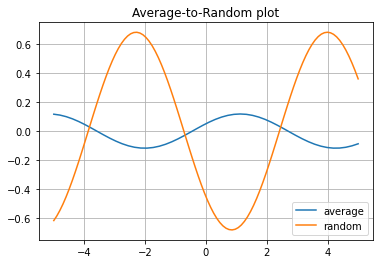

In [97]:
class SineWaveTask:
    def __init__(self):
        self.a = np.random.uniform(0.1, 5.0)
        self.b = np.random.uniform(0, 2*np.pi) 
        self.train_x = None 
    
    def f(self, x):
        return self.a * np.sin(x + self.b)

    def training_set(self, size=10, force_new=False):
        if self.train_x is None and not force_new:
            self.train_x = np.random.uniform(-5, 5, size) 
            x = self.train_x 
        elif not force_new: 
            x = self.train_x 
        else: 
            x = np.random.uniform(-5, 5, size) 
        y = self.f(x) 
        return x, y
    
    def test_set(self, size=50):
        x = np.linspace(-5, 5, size)
        y = self.f(x) 
        return x, y

    def plot(self, *args, **kwargs):
        x, y = self.test_set(size=100)
        return plt.plot(x, y, *args, **kwargs)


y_avg = np.zeros(50)
for i in range(1000):
    swt = SineWaveTask()
    x, curr_y = swt.test_set()
    y_avg += curr_y

y_avg /= 1000
plt.figure()
plt.plot(x, y_avg, '-', label='average')
SineWaveTask().plot('-', label='random')
plt.legend()
plt.grid(); plt.title("Average-to-Random plot")
plt.show()

In [ ]:
xs, ys = 

In [72]:
import tensorflow as tf 
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.activations import relu 
from tensorflow.keras import losses 

# Build a Single Task sine function regression model

In [99]:
import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense 


In [100]:
class SineModel(Model):
    def __init__(self):
        super(SineModel, self).__init__() 
        self.hidden1 = Dense(40, activation='relu', input_shape=(1,))
        self.hidden2 = Dense(40, activation='relu')
        self.out = Dense(1, activation='linear')
    
    def call(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x) 
        x = self.out(x)
        return x 

    

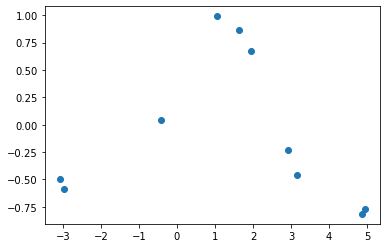

In [105]:
sinu_generator = SineWaveTask()
train_xs, train_ys = sinu_generator.training_set(size=10, force_new=True)
train_xs, train_ys 

plt.plot(train_xs, train_ys, 'o')
plt.show()